<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "EC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/EC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


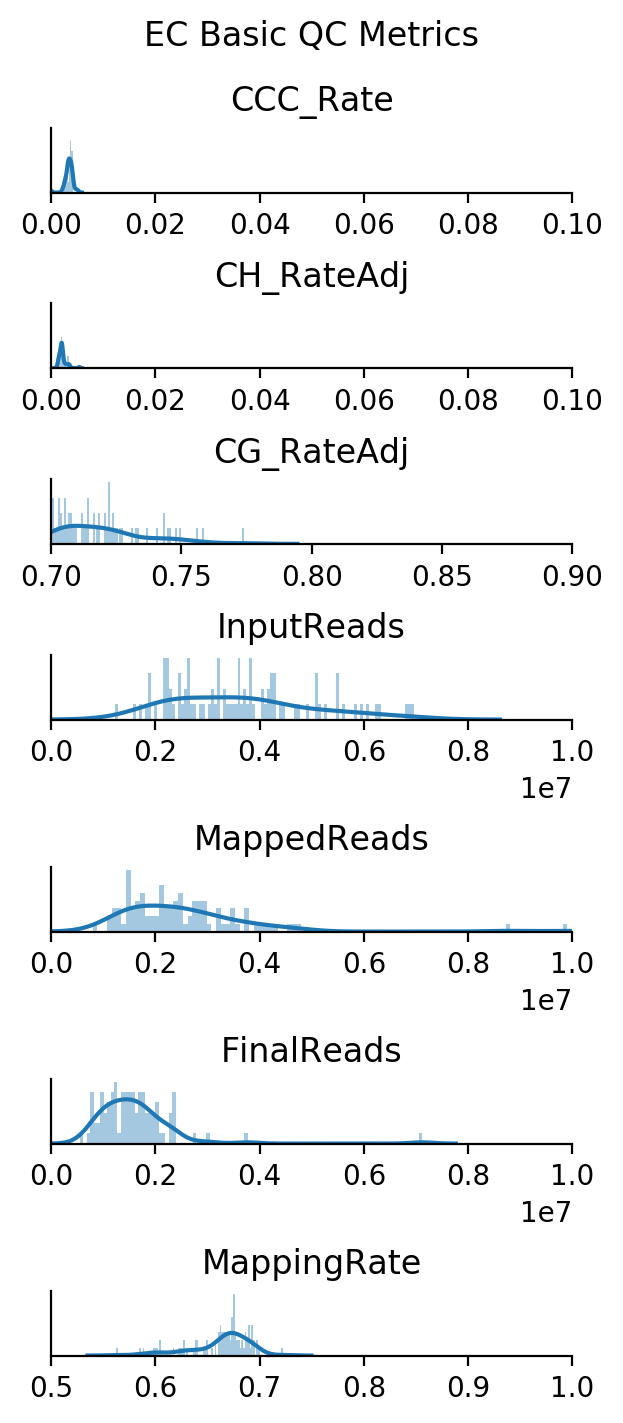

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

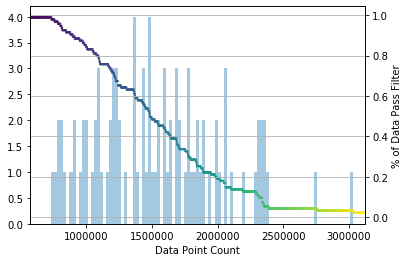

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 95/95 (100.0%)
CG_RateAdj passed 95/95 (100.0%)
CH_RateAdj passed 95/95 (100.0%)
FinalReads passed 95/95 (100.0%)
MappingRate passed 95/95 (100.0%)
Overall passed 95/95 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1
171207 2
171214 1
180123 1
180129 1
180206 1
180208 2
180212 3
180213 3
180222 2
180226 1
180312 2
180319 2
180326 1
180329 2
180402 1
180403 1
180409 1
180417 1
180419 1
180423 1
180424 2
180529 1
180605 1
180917 1
180925 2
181009 2
181022 7
181023 2
181206 1
181218 1
181220 1
190117 5
190122 1
190124 3
190131 1
190205 2
190214 7
190219 4
190305 4
190307 3
190625 1
190627 2
190711 5
190716 5


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 16 4.2%
ad002 14 3.6%
ad004 14 3.6%
ad006 12 3.1%
ad007 12 3.1%
ad008 10 2.6%
ad010 11 2.9%
ad012 6 1.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_2362,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003623,0.717339,0.716311,0.005655,0.002039,1978963.0,5259978,3363508.0,10E,...,-25.793955,5.093968,-41.889704,16.107874,EC,4.969964,8.632051,-32.276503,32.837472,True
10E_M_2828,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003500,0.694823,0.693751,0.005426,0.001933,1771867.0,4938238,3247909.0,10E,...,-26.181782,4.843077,-42.548821,15.428428,EC,4.986272,8.941058,-32.858120,32.838560,True
10E_M_401,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003993,0.683342,0.682073,0.006007,0.002022,1372198.0,3629204,2277077.0,10E,...,-26.981379,4.886460,-44.751252,15.378854,EC,4.479764,9.169078,-33.493537,33.620498,True
11E_M_1738,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.003474,0.713247,0.712247,0.005563,0.002096,1950490.0,5525978,3480399.0,11E,...,-26.008591,4.736109,-42.506814,15.486066,EC,4.999623,9.051251,-33.160708,32.946430,True
11F_M_1074,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.003854,0.706652,0.705518,0.005966,0.002121,1262491.0,2696112,1840752.0,11F,...,-25.811333,5.128738,-41.712849,16.201791,EC,5.060801,8.544257,-32.014247,32.623057,True
11F_M_1360,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.003787,0.707675,0.706563,0.005903,0.002123,1833970.0,4185866,2795627.0,11F,...,-25.954273,4.978240,-42.185849,15.704067,EC,5.032056,8.795487,-32.475346,32.748556,True
11F_M_1929,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.003508,0.706256,0.705222,0.005597,0.002097,1098915.0,2229538,1509658.0,11F,...,-25.742836,5.035082,-41.870428,16.161799,EC,4.943002,8.551980,-32.368347,32.882278,True
11F_M_2590,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.004096,0.746716,0.745675,0.007926,0.003845,1794474.0,4149148,2790501.0,11F,...,-23.974035,4.554368,-38.489981,20.546275,EC,4.935293,7.718228,-29.878410,32.264884,True
11F_M_2688,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.004257,0.748768,0.747694,0.007897,0.003655,2305072.0,5094692,3539422.0,11F,...,-24.645435,4.633598,-39.613762,20.075560,EC,4.924670,7.765318,-29.931018,32.285570,True
